In [139]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

%matplotlib inline
%matplotlib notebook

from glob import glob

timer = cy.timing.Timer()
time = timer.time

## load all-in-one dataframe

In [2]:
df = pd.read_pickle("/data/user/cjchen/2020-2021/Spring2021/greco_grb/data/grbwebgbm/grbweb_gbm_healpix.pkl")

In [3]:
df.head()

,grb_name,grb_name_GBM,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center,hasHealpix,probs
0,GRB190613B,GRB190613449,305.431917,-4.646667,58647.449285,0.001905,0.000056,0,0.000056,NaN,58647.450238,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,GRB190613A,GRB190613172,182.529208,67.235278,58647.171736,0.000204,0.000198,0,0.000056,NaN,58647.171838,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,GRB190612A,GRB190612165,223.950000,62.100000,58646.164836,0.001677,0.001677,1,7.025096,NaN,58646.165675,True,"[4.93177310545434e-07, 5.200280384087819e-07, ..."
3,GRB190611B,GRB190611950,84.758333,50.833333,58645.949833,0.001217,0.001164,0,5.900000,NaN,58645.950442,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,GRB190611A,None,324.722625,-56.074278,58645.742373,0.000484,0.000484,0,0.000194,NaN,58645.742615,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
df.describe()

,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center
count,2051.000000,2051.000000,2051.000000,2.051000e+03,2.051000e+03,2051.000000,1976.000000,190.000000,2051.000000
mean,180.040867,0.860048,57357.629307,5.546341e-04,4.947011e-04,0.590444,3.618384,1.935815,57357.629584
std,103.475898,40.029533,750.527179,8.848945e-04,7.284576e-04,0.491872,3.789631,1.477243,750.527168
min,0.270000,-87.580000,56043.584981,9.259259e-08,9.259259e-08,0.000000,0.000000,0.009300,56043.585160
25%,91.610187,-30.231667,56720.703103,8.333333e-05,7.703704e-05,0.000000,0.000398,0.801750,56720.703870
50%,180.980000,0.616667,57343.442301,2.874074e-04,2.637037e-04,1.000000,3.165577,1.502500,57343.442640
75%,270.890458,32.386500,58006.817425,6.844502e-04,6.118519e-04,1.000000,5.636223,2.692750,58006.817563
max,359.740000,87.301167,58647.449285,1.643403e-02,9.591111e-03,1.000000,37.500000,7.800000,58647.450238


In [8]:
data_dir = '/data/user/cjchen/csky/analyses/online_GRECO/version-002-p04'
data_filenames = sorted(glob(data_dir + '/IC86_20*.data_with_angErr.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged_with_angErr.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

min_log_e = 1.0
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 5, 30+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]

In [9]:
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.4', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/cjchen/2020-2021/Spring2021/0118-0122')
ana = cy.get_analysis(cy.selections.repo, dataset_spec, dir=ana_dir, load_sig=True)

Setting up Analysis for:
greco_v2.4
Setting up greco_v2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [11]:
conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'prior', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'extended': True,
    }

cy.CONF['mp_cpus'] = 4

In [12]:
cy.CONF.update(conf)

In [13]:
cy.CONF

{'mp_cpus': 4,
 'ana': Analysis(keys=[greco_v2.4]),
 'space': 'prior',
 'time': 'transient',
 'energy': 'customflux',
 'flux': PowerLawFlux(gamma=2),
 'sig': 'transient',
 'extended': True}

## Test on one GRB

In [49]:
df.index[df['grb_name_GBM'] == "GRB180423033"]

Int64Index([342], dtype='int64')

In [50]:
df.loc[342,:]

grb_name                                                     GRB180423A
grb_name_GBM                                               GRB180423033
ra                                                               208.68
dec                                                                9.84
mjd_start                                                         58231
t100                                                        0.000634074
t90                                                         0.000634074
gbm                                                                   1
source_uncertainty                                              4.79466
redshift                                                            NaN
t_center                                                          58231
hasHealpix                                                         True
probs                 [1.5936671470331842e-13, 6.830134873479776e-14...
Name: 342, dtype: object

In [231]:
idx = 342;
tw_in_second = 10.

name = df.grb_name[idx]
ra = df.ra[idx]
dec = df.dec[idx]
tw_start = df.mjd_start[idx] + 0.5*(df.t100[idx] - tw_in_second/86400.)
tw = tw_in_second/86400.
healpix = df.probs[idx]

src = cy.utils.Sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    prior=[hl.heal.HealHist(healpix)],
    name=name
)

In [232]:
tr = cy.get_trial_runner(src=src)

In [180]:
n_trials = 1e3

rng=np.random.default_rng(int(src.name[0][3:-1]))
seeds = rng.integers(1e9, size=int(n_trials))
fits = []
with time('fits from n_trials'):
    for no_trial, seed in enumerate(seeds):
        if no_trial % 100 == 0:
            print("Working on no_trial: {} \n".format(no_trial))
        bg_trial = tr.get_one_trial(0, seed=seed)
        fit = tr.get_one_fit_from_trial(
            bg_trial, 
            TRUTH=False, 
            logging=False
        )
        fits.append(fit)

Working on no_trial: 0 

Working on no_trial: 100 

Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 4558 locations using 4 cores:
       4558/4558 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Working on no_trial: 200 

Scanning 155382 locations using 4 cores:
     155382/155382 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 65145 locations using 4 cores:
      65145/65145 coordinates complete.   
Scanning 113436 locations using 4 cores:
     113436/113436 coordinates complete.   
Working on no_trial: 300 

Scanning 56649 locations using 4 cores:
      56649/56649 coordinates complete.   
Scanning 183739 locations using 4 cores:
     183739/183739 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363

In [194]:
print(tr.format_result(fits[-1]))

TS                  0.0
ns                  0.0


In [183]:
from copy import deepcopy
fits_copy=deepcopy(fits)

In [196]:
fits_df = pd.DataFrame(fits_copy, columns=['TS', 'ns'])

In [198]:
# fits_df.to_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(idx, int(n_trials), tw_in_second))


In [92]:
hp.nside2npix(128)

196608

In [199]:
fits_df = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(idx, int(n_trials), tw_in_second))


In [203]:
bg=cy.dists.Chi2TSD(fits_df.TS)

In [205]:
print(bg.description)

Chi2TSD from 1000 trials:
           eta = 0.017
          ndof = 1.694
           loc = 0.098
         scale = 1.145
Thresholds from trials:
        median = 0.000
       1 sigma = 0.00
       2 sigma = 0.00
       3 sigma = 5.25
       4 sigma = 13.57
       5 sigma = 24.16
Thresholds from fit:
        median = 0.000
       1 sigma = 0.00
       2 sigma = 0.00
       3 sigma = 5.25
       4 sigma = 13.57
       5 sigma = 24.16


<IPython.core.display.Javascript object>


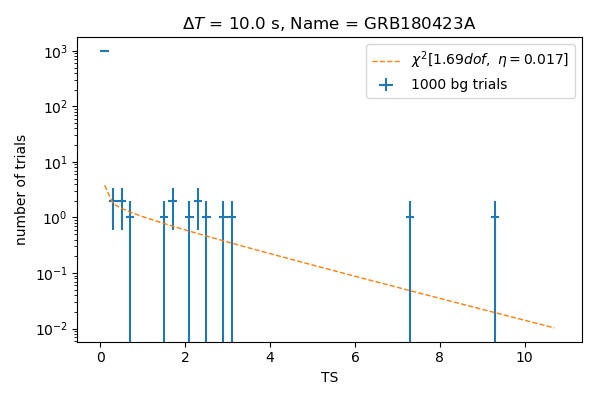

In [220]:
fig, ax = plt.subplots(dpi=100)
h = bg.get_hist(bins=np.r_[0:11:0.2])
hl.plot1d(ax, h, crosses=True, label='{} bg trials'.format(bg.n_total))
# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f} dof,\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_title('$\Delta T$ = {} s, Name = {}'.format(tw_in_second, src.name[0]))
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [238]:
df.loc[340,:]

grb_name                                                     GRB180425A
grb_name_GBM                                                       None
ra                                                              64.4516
dec                                                            -32.9522
mjd_start                                                       58233.3
t100                                                         0.00012963
t90                                                          0.00012963
gbm                                                                   0
source_uncertainty                                          0.000181219
redshift                                                            NaN
t_center                                                        58233.3
hasHealpix                                                        False
probs                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 340, dtype: object

In [234]:
def getBkgTS(grb_idx=0, tw_in_second=10, n_trials=1e2):
    
    
    idx = grb_idx;
    tw_in_second = 1.0*tw_in_second

    name = df.grb_name[idx]
    ra = df.ra[idx]
    dec = df.dec[idx]
    tw_start = df.mjd_start[idx] + 0.5*(df.t100[idx] - tw_in_second/86400.)
    tw = tw_in_second/86400.
    healpix = df.probs[idx]

    src = cy.utils.Sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=name
    )
    
    rng=np.random.default_rng(int(src.name[0][3:-1]))
    seeds = rng.integers(1e9, size=int(n_trials))
    fits = []
    with time('fits from n_trials'):
        for no_trial, seed in enumerate(seeds):
            if no_trial % 100 == 0:
                print("Working on no_trial: {} \n".format(no_trial))
            bg_trial = tr.get_one_trial(0, seed=seed)
            fit = tr.get_one_fit_from_trial(
                bg_trial, 
                TRUTH=False, 
                logging=False
            )
            fits.append(fit)
            
    return fits

In [239]:
fits = getBkgTS(grb_idx=340, tw_in_second=10, n_trials=1e3)

Working on no_trial: 0 

Scanning 98079 locations using 4 cores:
      98079/98079 coordinates complete.   
Scanning 21541 locations using 4 cores:
      21541/21541 coordinates complete.   
Scanning 178522 locations using 4 cores:
     178522/178522 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Working on no_trial: 100 

Scanning 168530 locations using 4 cores:
     168530/168530 coordinates complete.   
Scanning 171855 locations using 4 cores:
     171855/171855 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 187181 locations using 4 cores:
     187181/187181 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 96794 locations using 4 cores:
      96794/96794 coordinates complete.   
Scanning 105242 locations using 4 cores:
     105242/105242 coordinates complete.   
Scanning 187363 loc

In [240]:
from copy import deepcopy
fits_copy=deepcopy(fits)
fits_df = pd.DataFrame(fits_copy, columns=['TS', 'ns'])
# fits_df.to_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(340, int(1e3), 10))



<IPython.core.display.Javascript object>


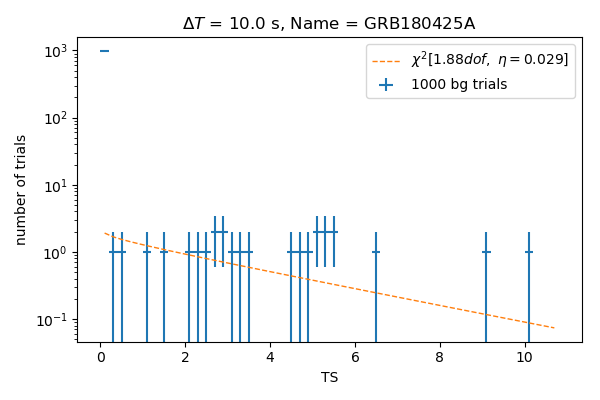

In [243]:
fits_df = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(340, int(1e3), 10))
bg=cy.dists.Chi2TSD(fits_df.TS)

fig, ax = plt.subplots(dpi=100)
h = bg.get_hist(bins=np.r_[0:11:0.2])
hl.plot1d(ax, h, crosses=True, label='{} bg trials'.format(bg.n_total))
# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f} dof,\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_title('$\Delta T$ = {} s, Name = {}'.format(tw_in_second, df.grb_name[340]))
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

## TS with spatial prior on GRB180423033

In [ ]:
grbweb = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/grbweb/grb_grbweb.pkl")
# probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn120426585_v00.fit")
# grbweb.loc[grbweb['grb_name_GBM'] == "GRB120426585"]

probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn180423033_v00.fit")
grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"]


In [ ]:
probs_copy = np.sort(probs)
cdf = np.cumsum(probs_copy)
probs90 = probs_copy[(np.abs(cdf - 0.1)).argmin()]

In [ ]:
cmap = cm.Reds
cmap.set_under("w")

# pixels = np.where((0 != probs) & (9.5e-7 < probs) & (probs < 1e-6))[0]  # Get the circle around the GBM burst
pixels = np.where((probs > 0.95*probs90) & (probs < 1.05*probs90))[0]

THETA, PHI = hp.pixelfunc.pix2ang(128, pixels)  # Get all the angles for this circle
pixarea = hp.pixelfunc.nside2pixarea(128, degrees=True)
hp.mollview(probs/pixarea, cbar=True, coord='C',unit=r'Probability per Pixel Area',rot=180, cmap=cmap, min=0, max=np.max(probs/pixarea), title='GBM Map')
hp.graticule()

hp.projscatter(THETA, PHI, color='tomato', alpha=0.3)


In [ ]:
src = cy.S

In [230]:
np.rad2deg(hp.nside2resol(128)),hp.nside2pixarea(128, degrees=True)**0.5

(0.45806485490898746, 0.4580648549089874)

In [229]:
np.rad2deg(hp.nside2resol(64)), hp.nside2pixarea(64, degrees=True)**0.5

(0.9161297098179749, 0.9161297098179748)

In [244]:
hp.nside2npix(128), hp.nside2npix(64)

(196608, 49152)

In [ ]:
m = hl.heal.hist(128, [0], [np.pi]).smoothing(np.radians(10)).normalize()
m.map = np.maximum(1e-4, m.map)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(m.map), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale, a.u.)')
plt.tight_layout()

In [ ]:
ra = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].ra
dec = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].dec
mjd = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].mjd_start
mjd

In [ ]:
np.sum(m.map)